# Housing Sale Price Prediction : Advanced Regression Assignment

## Steps
1. Reading and Understanding the data
2. Data Inspection and Missing Value Treatment
3. Data Analysis and Visualization
4. Preparing the data for Modelling
    - Dummy Encoding
    - Train - Test split
    - Rescaling
5. Training the Model
6. Regularization and Tuning
7. Residual Analysis
8. Predictions and Evaluations on the test set

### Step 1: Reading and understanding the data

In [324]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data
# Some of the columns have NA explicitely defined and it represents a particular category. So it shouldn't be treated as missing value. Hence reading them as string
cols_custom_read = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType',\
                    'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
custom_converters = {c : str for c in cols_custom_read}

housing_data = pd.read_csv('https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv', converters=custom_converters)
housing_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [3]:
# Understand the shape of the data
housing_data.shape

(1460, 81)

#### Observations
- Number of datapoints is 1460 which seems to be less
- There are 80 independent variables

In [4]:
# Understand the data types, presence of missing values
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Step 2: Data Inspection and Missing Value Treatment

##### MSSubClass

In [5]:
housing_data['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [6]:
print(housing_data['MSSubClass'].dtypes)

int64


In [7]:
housing_data['MSSubClass'].isna().sum()
# No Missing value

0

In [8]:
#Since this is described as Categorical Variable in Data dictionary, convert to Object. Avoiding to map them to actual description otherwise it will be too verbose
housing_data['MSSubClass'] = housing_data['MSSubClass'].astype("object")

##### MSZoning

In [9]:
housing_data['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

- C (all) is not part of data dictonary. But let's assume it is one of the category and proceed

In [10]:
print(housing_data['MSZoning'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [11]:
housing_data['MSZoning'].isna().sum()
# No Missing value

0

##### LotFrontage

In [12]:
housing_data['LotFrontage'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])

## Looks like data is skewed towards max

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
90%        96.000000
99%       141.000000
100%      313.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [13]:
print(housing_data['LotFrontage'].dtypes)
# Continuous variable and dtype is float so no need to convert

float64


In [14]:
housing_data['LotFrontage'].isna().sum()
# There are missing values

259

In [15]:
# Going with median to impute the value as mean would be heavily skewed by the outliers in this case
median_lot_frontage = housing_data['LotFrontage'].describe()['50%']
housing_data['LotFrontage'].fillna(median_lot_frontage,inplace=True)

##### LotArea

In [16]:
housing_data['LotArea'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])
## Looks like data is skewed towards max

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
90%       14381.700000
99%       37567.640000
100%     215245.000000
max      215245.000000
Name: LotArea, dtype: float64

In [17]:
print(housing_data['LotArea'].dtypes)
# Continuous variable and dtype is float so no need to convert

int64


In [18]:
housing_data['LotArea'].isna().sum()
# There are missing values

0

##### Street

In [19]:
housing_data['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [20]:
print(housing_data['Street'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [21]:
housing_data['Street'].isna().sum()
# No Missing value

0

##### Alley

In [22]:
housing_data['Alley'].value_counts()

NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [23]:
print(housing_data['Alley'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [24]:
housing_data['Alley'].isna().sum()
# No Missing Values

0

In [25]:
# Map NA to No Alley for better description
housing_data['Alley'] = housing_data['Alley'].apply(lambda x : 'NoAlley' if x == 'NA' else x)
housing_data['Alley'].value_counts()

NoAlley    1369
Grvl         50
Pave         41
Name: Alley, dtype: int64

##### LotShape

In [26]:
housing_data['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [27]:
print(housing_data['LotShape'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [28]:
housing_data['LotShape'].isna().sum()
# No Missing Values

0

##### LandContour

In [29]:
housing_data['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [30]:
print(housing_data['LandContour'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [31]:
housing_data['LandContour'].isna().sum()
# No Missing Values

0

##### Utilities

In [32]:
housing_data['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [33]:
print(housing_data['Utilities'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [34]:
housing_data['Utilities'].isna().sum()
# No Missing Values

0

##### LotConfig

In [35]:
housing_data['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [36]:
print(housing_data['LotConfig'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [37]:
housing_data['LotConfig'].isna().sum()
# No Missing Values

0

##### LandSlope

In [38]:
housing_data['LandSlope'].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [39]:
print(housing_data['LandSlope'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [40]:
housing_data['LandSlope'].isna().sum()
# No Missing Values

0

##### Neighborhood

In [41]:
housing_data['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [42]:
print(housing_data['Neighborhood'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [43]:
housing_data['Neighborhood'].isna().sum()
# No Missing Values

0

##### Condition1

In [44]:
housing_data['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [45]:
print(housing_data['Condition1'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [46]:
housing_data['Condition1'].isna().sum()
# No Missing Values

0

##### Condition2

In [47]:
housing_data['Condition2'].value_counts()

Norm      1445
Feedr        6
RRNn         2
PosN         2
Artery       2
RRAn         1
RRAe         1
PosA         1
Name: Condition2, dtype: int64

In [48]:
print(housing_data['Condition2'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [49]:
housing_data['Condition2'].isna().sum()
# No Missing Values

0

##### BldgType

In [50]:
housing_data['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [51]:
print(housing_data['BldgType'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [52]:
housing_data['BldgType'].isna().sum()
# No Missing Values

0

##### HouseStyle

In [53]:
housing_data['HouseStyle'].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [54]:
print(housing_data['HouseStyle'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [55]:
housing_data['HouseStyle'].isna().sum()
# No Missing Values

0

##### OverallQual

In [56]:
housing_data['OverallQual'].value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

In [57]:
print(housing_data['OverallQual'].dtypes)
# Ordinal Categorical variable and dtype is int so no need to convert

int64


In [58]:
housing_data['OverallQual'].isna().sum()
# No Missing Values

0

In [59]:
# Since OverallQual is ordinal categorical variable, use label encoding 
housing_data['OverallQual'] = LabelEncoder().fit_transform(housing_data['OverallQual'])


##### OverallCond

In [60]:
housing_data['OverallCond'].value_counts()

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

In [61]:
print(housing_data['OverallCond'].dtypes)
# Ordinal Categorical variable and dtype is int so no need to convert

int64


In [62]:
housing_data['OverallCond'].isna().sum()
# No Missing Values

0

In [63]:
# Since OverallCond is ordinal categorical variable, use label encoding 
housing_data['OverallCond'] = LabelEncoder().fit_transform(housing_data['OverallCond'])

##### YearBuilt

In [64]:
housing_data['YearBuilt'].value_counts()

2006    67
2005    64
2004    54
2007    49
2003    45
        ..
1906     1
1911     1
1913     1
1917     1
1872     1
Name: YearBuilt, Length: 112, dtype: int64

In [65]:
print(housing_data['YearBuilt'].dtypes)
# Ordinal Categorical variable and dtype is int, so no change needed

int64


In [66]:
housing_data['YearBuilt'] = LabelEncoder().fit_transform(housing_data['YearBuilt'])

In [67]:
housing_data['YearBuilt'].isna().sum()
# No Missing Values

0

##### YearRemodAdd

In [68]:
housing_data['YearRemodAdd'].value_counts()

1950    178
2006     97
2007     76
2005     73
2004     62
       ... 
2010      6
1983      5
1952      5
1986      5
1951      4
Name: YearRemodAdd, Length: 61, dtype: int64

In [69]:
print(housing_data['YearRemodAdd'].dtypes)
# Ordinal Categorical variable and dtype is int, so no change needed

int64


In [70]:
housing_data['YearRemodAdd'] = LabelEncoder().fit_transform(housing_data['YearRemodAdd'])

In [71]:
housing_data['YearRemodAdd'].isna().sum()
# No Missing Values

0

##### RoofStyle

In [72]:
housing_data['RoofStyle'].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [73]:
print(housing_data['RoofStyle'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [74]:
housing_data['RoofStyle'].isna().sum()
# No Missing Values

0

##### RoofMatl

In [75]:
housing_data['RoofMatl'].value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64

In [76]:
print(housing_data['RoofMatl'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [77]:
housing_data['RoofMatl'].isna().sum()
# No Missing Values

0

##### Exterior1st

In [78]:
housing_data['Exterior1st'].value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
ImStucc      1
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64

In [79]:
print(housing_data['Exterior1st'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [80]:
housing_data['Exterior1st'].isna().sum()
# No Missing Values

0

##### Exterior2nd

In [81]:
housing_data['Exterior2nd'].value_counts()

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [82]:
print(housing_data['Exterior2nd'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [83]:
housing_data['Exterior2nd'].isna().sum()
# No Missing Values

0

##### MasVnrType

In [84]:
housing_data['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [85]:
print(housing_data['MasVnrType'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [86]:
housing_data['MasVnrType'].isna().sum()

8

In [87]:
#Imputing MasVnrType with Mode. 
mode_mas_vnr_type = housing_data['MasVnrType'].mode()[0]
print(f"Mode: {mode_mas_vnr_type}")
housing_data['MasVnrType'].fillna(mode_mas_vnr_type,inplace=True)

Mode: None


##### MasVnrArea

In [88]:
housing_data['MasVnrArea'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])
## Data is skewed towards right

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
90%       335.000000
99%       791.920000
100%     1600.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [89]:
print(housing_data['MasVnrArea'].dtypes)
# Continuous variable and dtype is float, so no need to convert

float64


In [90]:
housing_data['MasVnrArea'].isna().sum()

8

In [91]:
# Since Missing values for MasVnrArea is exactly where MasVnrType is missing, we have to consider the value for Mode while imputing MasVnrArea
#Since Mode for MasVnrType is none, corresponding MasVnrArea should be 0
imputed_mas_vnr_area = 0
housing_data['MasVnrArea'].fillna(imputed_mas_vnr_area,inplace=True)

##### ExterQual

In [92]:
housing_data['ExterQual'].value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [93]:
print(housing_data['ExterQual'].dtypes)
# ExterQual is Ordinal Categorical variable, so it should be label encoded 

object


In [94]:
housing_data['ExterQual'].isna().sum()

0

In [95]:
# Label Encode ExterQual
housing_data['ExterQual'] = housing_data['ExterQual'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_data['ExterQual'].value_counts()

2    906
3    488
4     52
1     14
Name: ExterQual, dtype: int64

##### ExterCond

In [96]:
housing_data['ExterCond'].value_counts()

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [97]:
print(housing_data['ExterCond'].dtypes)
# ExterCond is Ordinal Categorical variable, so it should be label encoded 

object


In [98]:
housing_data['ExterCond'].isna().sum()

0

In [99]:
# Label Encode ExterCond
housing_data['ExterCond'] = housing_data['ExterCond'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_data['ExterCond'].value_counts()

2    1282
3     146
1      28
4       3
0       1
Name: ExterCond, dtype: int64

##### Foundation

In [100]:
housing_data['Foundation'].value_counts()

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

In [101]:
print(housing_data['Foundation'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [102]:
housing_data['Foundation'].isna().sum()

0

##### BsmtQual

In [103]:
housing_data['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: BsmtQual, dtype: int64

In [104]:
print(housing_data['BsmtQual'].dtypes)
# BsmtQual is Ordinal Categorical variable, so it should be label encoded 

object


In [105]:
housing_data['BsmtQual'].isna().sum()

0

In [106]:
# Label Encode BsmtQual
housing_data['BsmtQual'] = housing_data['BsmtQual'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_data['BsmtQual'].value_counts()

3    649
4    618
5    121
0     37
2     35
Name: BsmtQual, dtype: int64

##### BsmtCond

In [107]:
housing_data['BsmtCond'].value_counts()

TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: BsmtCond, dtype: int64

In [108]:
print(housing_data['BsmtCond'].dtypes)
# BsmtCond is Ordinal Categorical variable, so it should be label encoded 

object


In [109]:
housing_data['BsmtCond'].isna().sum()

0

In [110]:
# Label Encode BsmtCond
housing_data['BsmtCond'] = housing_data['BsmtCond'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_data['BsmtCond'].value_counts()

3    1311
4      65
2      45
0      37
1       2
Name: BsmtCond, dtype: int64

##### BsmtExposure

In [111]:
housing_data['BsmtExposure'].value_counts()

No    953
Av    221
Gd    134
Mn    114
NA     38
Name: BsmtExposure, dtype: int64

In [112]:
print(housing_data['BsmtExposure'].dtypes)
# BsmtExposure is Ordinal Categorical variable, so it should be label encoded 

object


In [113]:
housing_data['BsmtExposure'].isna().sum()

0

In [114]:
# Label Encode BsmtExposure
housing_data['BsmtExposure'] = housing_data['BsmtExposure'].map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
housing_data['BsmtExposure'].value_counts()

1    953
3    221
4    134
2    114
0     38
Name: BsmtExposure, dtype: int64

##### BsmtFinType1

In [115]:
housing_data['BsmtFinType1'].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NA      37
Name: BsmtFinType1, dtype: int64

In [116]:
print(housing_data['BsmtFinType1'].dtypes)
# BsmtFinType1 is Ordinal Categorical variable, so label encode

object


In [117]:
housing_data['BsmtFinType1'].isna().sum()

0

In [118]:
# Label Encode BsmtFinType1
housing_data['BsmtFinType1'] = housing_data['BsmtFinType1'].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
housing_data['BsmtFinType1'].value_counts()

1    430
6    418
5    220
4    148
3    133
2     74
0     37
Name: BsmtFinType1, dtype: int64

##### BsmtFinSF1

In [119]:
housing_data['BsmtFinSF1'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
90%      1065.500000
99%      1572.410000
100%     5644.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

In [120]:
print(housing_data['BsmtFinSF1'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [121]:
housing_data['BsmtFinSF1'].isna().sum()
# There are no missing values

0

##### BsmtFinType2

In [122]:
housing_data['BsmtFinType2'].value_counts()

Unf    1256
Rec      54
LwQ      46
NA       38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [123]:
print(housing_data['BsmtFinType2'].dtypes)
# BsmtFinType2 is Ordinal Categorical variable, so label encode

object


In [124]:
housing_data['BsmtFinType2'].isna().sum()

0

In [125]:
# Label Encode BsmtFinType2
housing_data['BsmtFinType2'] = housing_data['BsmtFinType2'].map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
housing_data['BsmtFinType2'].value_counts()

1    1256
3      54
2      46
0      38
4      33
5      19
6      14
Name: BsmtFinType2, dtype: int64

##### BsmtFinSF2

In [126]:
housing_data['BsmtFinSF2'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
90%       117.200000
99%       830.380000
100%     1474.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

In [127]:
print(housing_data['BsmtFinSF2'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [128]:
housing_data['BsmtFinSF2'].isna().sum()
# There are no missing values

0

##### BsmtUnfSF

In [129]:
housing_data['BsmtUnfSF'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
90%      1232.000000
99%      1797.050000
100%     2336.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

In [130]:
print(housing_data['BsmtUnfSF'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [131]:
housing_data['BsmtUnfSF'].isna().sum()
# There are no missing values

0

##### TotalBsmtSF

In [132]:
housing_data['TotalBsmtSF'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
90%      1602.200000
99%      2155.050000
100%     6110.000000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [133]:
print(housing_data['TotalBsmtSF'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [134]:
housing_data['TotalBsmtSF'].isna().sum()
# There are no missing values

0

##### Heating

In [135]:
housing_data['Heating'].value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [136]:
print(housing_data['Heating'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [137]:
housing_data['Heating'].isna().sum()
#No Missing Values

0

##### HeatingQC

In [138]:
housing_data['HeatingQC'].value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

In [139]:
print(housing_data['HeatingQC'].dtypes)
# HeatingQC is Ordinal Categorical variable, so it should be label encoded

object


In [140]:
housing_data['HeatingQC'].isna().sum()

0

In [141]:
# Label Encode HeatingQC
housing_data['HeatingQC'] = housing_data['HeatingQC'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_data['HeatingQC'].value_counts()

4    741
2    428
3    241
1     49
0      1
Name: HeatingQC, dtype: int64

##### CentralAir

In [142]:
housing_data['CentralAir'].value_counts()

Y    1365
N      95
Name: CentralAir, dtype: int64

In [143]:
print(housing_data['CentralAir'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [144]:
housing_data['CentralAir'].isna().sum()
#No Missing Values

0

##### Electrical

In [145]:
housing_data['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [146]:
print(housing_data['Electrical'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [147]:
housing_data['Electrical'].isna().sum()

1

In [148]:
#One missing value, impute with Mode
mode_electrical = housing_data['Electrical'].mode()[0]
print(f"Mode of Electrical: {mode_electrical}")
housing_data['Electrical'].fillna(mode_electrical,inplace=True)


Mode of Electrical: SBrkr


##### 1stFlrSF

In [149]:
housing_data['1stFlrSF'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])
#data is little skewed towards right

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
90%      1680.000000
99%      2219.460000
100%     4692.000000
max      4692.000000
Name: 1stFlrSF, dtype: float64

In [150]:
print(housing_data['1stFlrSF'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [151]:
housing_data['1stFlrSF'].isna().sum()
# There are no missing values

0

##### 2ndFlrSF

In [152]:
housing_data['2ndFlrSF'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
90%       954.200000
99%      1418.920000
100%     2065.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

In [153]:
print(housing_data['2ndFlrSF'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [154]:
housing_data['2ndFlrSF'].isna().sum()
# There are no missing values

0

##### LowQualFinSF

In [155]:
housing_data['LowQualFinSF'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])

#data is heavily skewed towards right

count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
90%         0.000000
99%       360.000000
100%      572.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

In [156]:
print(housing_data['LowQualFinSF'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [157]:
housing_data['LowQualFinSF'].isna().sum()
# There are no missing values

0

##### GrLivArea

In [158]:
housing_data['GrLivArea'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
90%      2158.300000
99%      3123.480000
100%     5642.000000
max      5642.000000
Name: GrLivArea, dtype: float64

In [159]:
print(housing_data['GrLivArea'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [160]:
housing_data['GrLivArea'].isna().sum()
# There are no missing values

0

##### BsmtFullBath

In [161]:
housing_data['BsmtFullBath'].value_counts()


0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

In [162]:
print(housing_data['BsmtFullBath'].dtypes)
# Ordinal Categorical variable and dtype is int so no need to convert. Also it is already label encoded so no encoding needed

int64


In [163]:
housing_data['BsmtFullBath'].isna().sum()
# There are no missing values

0

##### BsmtHalfBath

In [164]:
housing_data['BsmtHalfBath'].value_counts()


0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

In [165]:
print(housing_data['BsmtHalfBath'].dtypes)
# Ordinal Categorical variable and dtype is int so no need to convert. Also it is already label encoded so no encoding needed

int64


In [166]:
housing_data['BsmtHalfBath'].isna().sum()
# There are no missing values

0

##### FullBath

In [167]:
housing_data['FullBath'].value_counts()


2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

In [168]:
print(housing_data['FullBath'].dtypes)
# Ordinal Categorical variable and dtype is int so no need to convert. Also it is already label encoded so no encoding needed

int64


In [169]:
housing_data['FullBath'].isna().sum()
# There are no missing values

0

##### HalfBath

In [170]:
housing_data['HalfBath'].value_counts()


0    913
1    535
2     12
Name: HalfBath, dtype: int64

In [171]:
print(housing_data['HalfBath'].dtypes)
# Ordinal Categorical variable and dtype is int so no need to convert. Also it is already label encoded so no encoding needed

int64


In [172]:
housing_data['HalfBath'].isna().sum()
# There are no missing values

0

##### BedroomAbvGr

In [173]:
housing_data['BedroomAbvGr'].value_counts()


3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

In [174]:
print(housing_data['BedroomAbvGr'].dtypes)
# Ordinal Categorical variable and dtype is int so no need to convert. Also it is already label encoded so no encoding needed

int64


In [175]:
housing_data['BedroomAbvGr'].isna().sum()
# There are no missing values

0

##### KitchenAbvGr

In [176]:
housing_data['KitchenAbvGr'].value_counts()


1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [177]:
print(housing_data['KitchenAbvGr'].dtypes)
# Ordinal Categorical variable and dtype is int so no need to convert. Also it is already label encoded so no encoding needed

int64


In [178]:
housing_data['KitchenAbvGr'].isna().sum()
# There are no missing values

0

##### KitchenQual

In [179]:
housing_data['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

In [180]:
print(housing_data['KitchenQual'].dtypes)
# HeatingQC is Ordinal Categorical variable, so it should be label encoded

object


In [181]:
housing_data['KitchenQual'].isna().sum()

0

In [182]:
# Label Encode HeatingQC
housing_data['KitchenQual'] = housing_data['KitchenQual'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_data['KitchenQual'].value_counts()

2    735
3    586
4    100
1     39
Name: KitchenQual, dtype: int64

##### TotRmsAbvGrd

In [183]:
housing_data['TotRmsAbvGrd'].value_counts()


6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64

In [184]:
print(housing_data['TotRmsAbvGrd'].dtypes)
# Ordinal Categorical variable and dtype is int so no need to convert. Also it is already label encoded so no encoding needed

int64


In [185]:
housing_data['TotRmsAbvGrd'].isna().sum()
# There are no missing values

0

##### Functional

In [186]:
housing_data['Functional'].value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [187]:
print(housing_data['Functional'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [188]:
housing_data['Functional'].isna().sum()
# No Missing Values

0

##### Fireplaces

In [189]:
housing_data['Fireplaces'].value_counts()


0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [190]:
print(housing_data['Fireplaces'].dtypes)
# Ordinal Categorical variable and dtype is int so no need to convert. Also it is already label encoded so no encoding needed

int64


In [191]:
housing_data['Fireplaces'].isna().sum()
# There are no missing values

0

##### FireplaceQu

In [192]:
housing_data['FireplaceQu'].value_counts()

NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [193]:
print(housing_data['FireplaceQu'].dtypes)
# FireplaceQu is Ordinal Categorical variable, so it should be label encoded 

object


In [194]:
housing_data['FireplaceQu'].isna().sum()

0

In [195]:
# Label Encode BsmtCond
housing_data['FireplaceQu'] = housing_data['FireplaceQu'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_data['FireplaceQu'].value_counts()

0    690
4    380
3    313
2     33
5     24
1     20
Name: FireplaceQu, dtype: int64

##### GarageType

In [196]:
housing_data['GarageType'].value_counts()

Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [197]:
print(housing_data['GarageType'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [198]:
housing_data['GarageType'].isna().sum()
# No Missing Values

0

In [199]:
# Replace NA values to NoGarage for better readability
housing_data['GarageType'] = housing_data['GarageType'].apply(lambda x : 'NoGarage' if x == 'NA' else x)
housing_data['GarageType'].value_counts()

Attchd      870
Detchd      387
BuiltIn      88
NoGarage     81
Basment      19
CarPort       9
2Types        6
Name: GarageType, dtype: int64

##### GarageYrBlt

In [200]:
housing_data['GarageYrBlt'].value_counts()

2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1908.0     1
1927.0     1
1933.0     1
1900.0     1
1906.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

In [201]:
print(housing_data['GarageYrBlt'].dtypes)
# Ordinal Categorical variable and dtype is int/float, so no change needed

float64


In [202]:
housing_data['GarageYrBlt'].isna().sum()
# No Missing Values

81

In [203]:
housing_data['GarageYrBlt'] = LabelEncoder().fit_transform(housing_data['GarageYrBlt'])
# This will also encode Missing values (No Garage in this case) which is desired

##### GarageFinish

In [204]:
housing_data['GarageFinish'].value_counts()

Unf    605
RFn    422
Fin    352
NA      81
Name: GarageFinish, dtype: int64

In [205]:
print(housing_data['GarageFinish'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [206]:
housing_data['GarageFinish'].isna().sum()
# No Missing Values

0

In [207]:
# Replace NA values to NoGarage for better readability
housing_data['GarageFinish'] = housing_data['GarageFinish'].apply(lambda x : 'NoGarage' if x == 'NA' else x)
housing_data['GarageFinish'].value_counts()

Unf         605
RFn         422
Fin         352
NoGarage     81
Name: GarageFinish, dtype: int64

##### GarageCars

In [208]:
housing_data['GarageCars'].value_counts()


2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

In [209]:
print(housing_data['GarageCars'].dtypes)
# Ordinal Categorical variable and dtype is int so no need to convert. It is already label encoded

int64


In [210]:
housing_data['GarageCars'].isna().sum()
# There are no missing values

0

##### GarageArea

In [211]:
housing_data['GarageArea'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
90%       757.100000
99%      1002.790000
100%     1418.000000
max      1418.000000
Name: GarageArea, dtype: float64

In [212]:
print(housing_data['GarageArea'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [213]:
housing_data['GarageArea'].isna().sum()
# There are no missing values

0

##### GarageQual

In [214]:
housing_data['GarageQual'].value_counts()

TA    1311
NA      81
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [215]:
print(housing_data['GarageQual'].dtypes)
# GarageQual is Ordinal Categorical variable, so it should be label encoded 

object


In [216]:
housing_data['GarageQual'].isna().sum()

0

In [217]:
# Label Encode BsmtCond
housing_data['GarageQual'] = housing_data['GarageQual'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_data['GarageQual'].value_counts()

3    1311
0      81
2      48
4      14
5       3
1       3
Name: GarageQual, dtype: int64

##### GarageCond

In [218]:
housing_data['GarageCond'].value_counts()

TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [219]:
print(housing_data['GarageCond'].dtypes)
# FireplaceQu is Ordinal Categorical variable, so it should be label encoded 

object


In [220]:
housing_data['GarageCond'].isna().sum()

0

In [221]:
# Label Encode BsmtCond
housing_data['GarageCond'] = housing_data['GarageCond'].map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_data['GarageCond'].value_counts()

3    1326
0      81
2      35
4       9
1       7
5       2
Name: GarageCond, dtype: int64

##### PavedDrive

In [222]:
housing_data['PavedDrive'].value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [223]:
print(housing_data['PavedDrive'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [224]:
housing_data['PavedDrive'].isna().sum()
# No Missing Values

0

##### WoodDeckSF

In [225]:
housing_data['WoodDeckSF'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
90%       262.000000
99%       505.460000
100%      857.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

In [226]:
print(housing_data['WoodDeckSF'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [227]:
housing_data['WoodDeckSF'].isna().sum()
# There are no missing values

0

##### OpenPorchSF

In [228]:
housing_data['OpenPorchSF'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
90%       130.000000
99%       285.820000
100%      547.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

In [229]:
print(housing_data['OpenPorchSF'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [230]:
housing_data['OpenPorchSF'].isna().sum()
# There are no missing values

0

##### EnclosedPorch

In [231]:
housing_data['EnclosedPorch'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
90%       112.000000
99%       261.050000
100%      552.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

In [232]:
print(housing_data['EnclosedPorch'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [233]:
housing_data['EnclosedPorch'].isna().sum()
# There are no missing values

0

##### 3SsnPorch

In [234]:
housing_data['3SsnPorch'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
90%         0.000000
99%       168.000000
100%      508.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

In [235]:
print(housing_data['3SsnPorch'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [236]:
housing_data['3SsnPorch'].isna().sum()
# There are no missing values

0

##### ScreenPorch

In [237]:
housing_data['ScreenPorch'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
90%         0.000000
99%       268.050000
100%      480.000000
max       480.000000
Name: ScreenPorch, dtype: float64

In [238]:
print(housing_data['ScreenPorch'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [239]:
housing_data['ScreenPorch'].isna().sum()
# There are no missing values

0

##### PoolArea

In [240]:
housing_data['PoolArea'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])


count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
90%         0.000000
99%         0.000000
100%      738.000000
max       738.000000
Name: PoolArea, dtype: float64

In [241]:
print(housing_data['PoolArea'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [242]:
housing_data['PoolArea'].isna().sum()
# There are no missing values

0

##### PoolQC

In [243]:
housing_data['PoolQC'].value_counts()

NA    1453
Gd       3
Ex       2
Fa       2
Name: PoolQC, dtype: int64

In [244]:
print(housing_data['PoolQC'].dtypes)
# PoolQC is Ordinal Categorical variable, so it should be label encoded 

object


In [245]:
housing_data['PoolQC'].isna().sum()

0

In [246]:
# Label Encode PoolQC
housing_data['PoolQC'] = housing_data['PoolQC'].map({'NA':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_data['PoolQC'].value_counts()

0    1453
3       3
4       2
1       2
Name: PoolQC, dtype: int64

##### Fence

In [247]:
housing_data['Fence'].value_counts()

NA       1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

In [248]:
print(housing_data['Fence'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [249]:
housing_data['Fence'].isna().sum()
# No Missing Values

0

In [250]:
#Replace NA with NoFence for better readability
housing_data['Fence'] = housing_data['Fence'].apply(lambda x : 'NoFence' if x == 'NA' else x)
housing_data['Fence'].value_counts()

NoFence    1179
MnPrv       157
GdPrv        59
GdWo         54
MnWw         11
Name: Fence, dtype: int64

##### MiscFeature

In [251]:
housing_data['MiscFeature'].value_counts()

NA      1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64

In [252]:
print(housing_data['MiscFeature'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [253]:
housing_data['MiscFeature'].isna().sum()
# No Missing Values

0

In [254]:
#Replace NA with NoMisc for better readability
housing_data['MiscFeature'] = housing_data['MiscFeature'].apply(lambda x : 'NoMisc' if x == 'NA' else x)
housing_data['MiscFeature'].value_counts()

NoMisc    1406
Shed        49
Gar2         2
Othr         2
TenC         1
Name: MiscFeature, dtype: int64

##### MiscVal

In [255]:
housing_data['MiscVal'].describe(percentiles=[0.25,0.5,0.75,0.9,0.99,1])
#data is heavily skewed because of the nature of data (only less houses has MISC Feature)


count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
99%        700.000000
100%     15500.000000
max      15500.000000
Name: MiscVal, dtype: float64

In [256]:
print(housing_data['MiscVal'].dtypes)
# Continuous variable and dtype is int so no need to convert

int64


In [257]:
housing_data['MiscVal'].isna().sum()
# There are no missing values

0

##### MoSold

In [258]:
housing_data['MoSold'].value_counts()

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

In [259]:
print(housing_data['MoSold'].dtypes)
# Categorical variable and dtype is int, so convert to object

int64


In [260]:
housing_data['MoSold'].isna().sum()
# No Missing Values

0

In [261]:
#Convert the data type to object
housing_data['MoSold'] = housing_data['MoSold'].astype('object')

##### YrSold

In [262]:
housing_data['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [263]:
print(housing_data['YrSold'].dtypes)
# Ordinal Categorical variable and dtype is int/float, so no change needed

int64


In [264]:
housing_data['YrSold'].isna().sum()
# No Missing Values

0

In [265]:
housing_data['YrSold'] = LabelEncoder().fit_transform(housing_data['YrSold'])
housing_data['YrSold'].value_counts()

3    338
1    329
0    314
2    304
4    175
Name: YrSold, dtype: int64

##### SaleType

In [266]:
housing_data['SaleType'].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [267]:
print(housing_data['SaleType'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [268]:
housing_data['SaleType'].isna().sum()
# No Missing Values

0

##### SaleCondition

In [269]:
housing_data['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [270]:
print(housing_data['SaleCondition'].dtypes)
# Categorical variable and dtype is object so no need to convert

object


In [271]:
housing_data['SaleCondition'].isna().sum()
# No Missing Values

0

### Step 3: Data Analysis and Visualization

In [272]:
continuous_vars = list(housing_data.dtypes[housing_data.dtypes != np.object ].index)
categorical_vars = list(housing_data.dtypes[housing_data.dtypes == np.object].index)

In [273]:
#Remove SalePrice 
continuous_vars.remove('SalePrice')

<Figure size 1440x720 with 0 Axes>

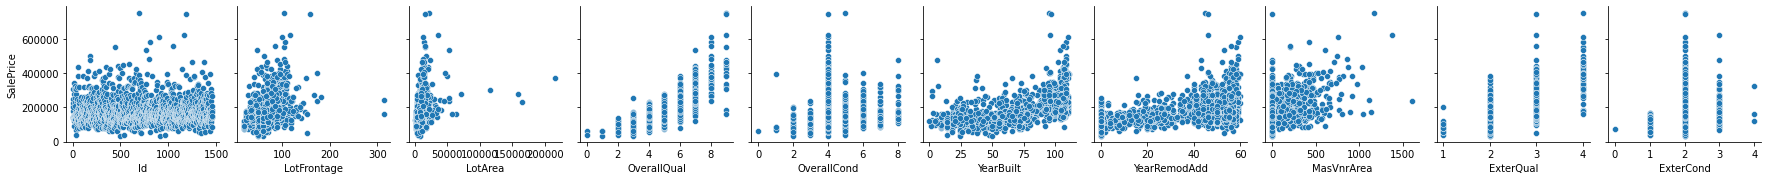

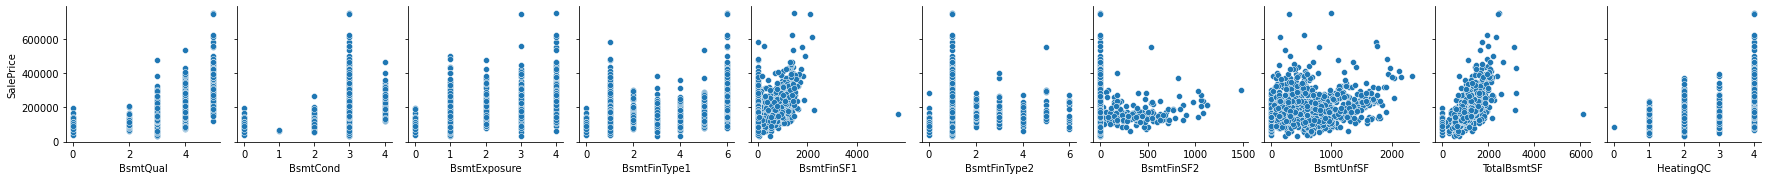

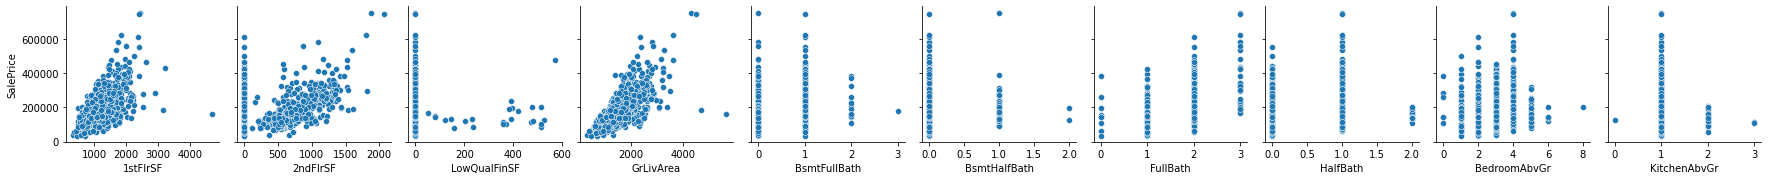

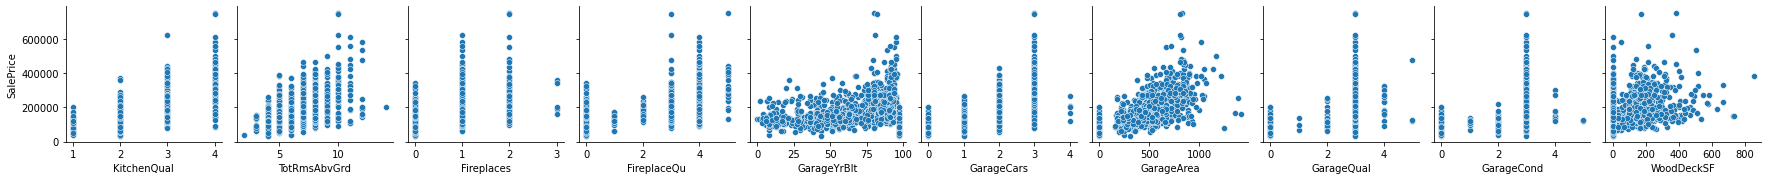

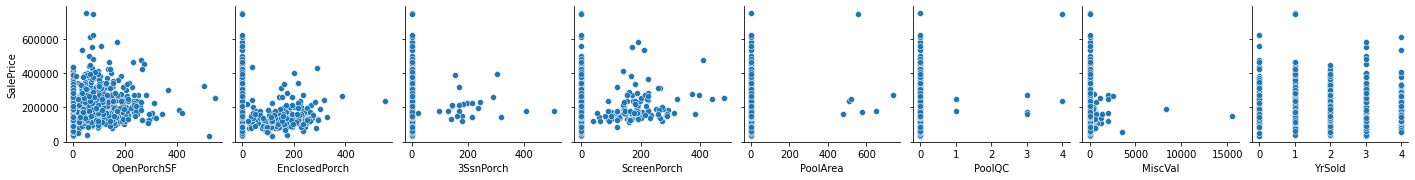

In [274]:
plt.figure(figsize=(20,10))
batch_size = 10
for i in range(0,len(continuous_vars),batch_size):
    sns.pairplot(data=housing_data,x_vars=continuous_vars[i:i+batch_size],y_vars='SalePrice')
plt.show()

#### Inferences
- Id is generated GUID and all unique values. Hence it should be dropped
- Almost all  Variables related to Quality/Condition (OverallQual, OverallCond, HeatingQC to name a few) seems to have a significant impact on the target variable
- TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GrLivArea and GarageArea if present seems to have a linear relationship with SalePrice



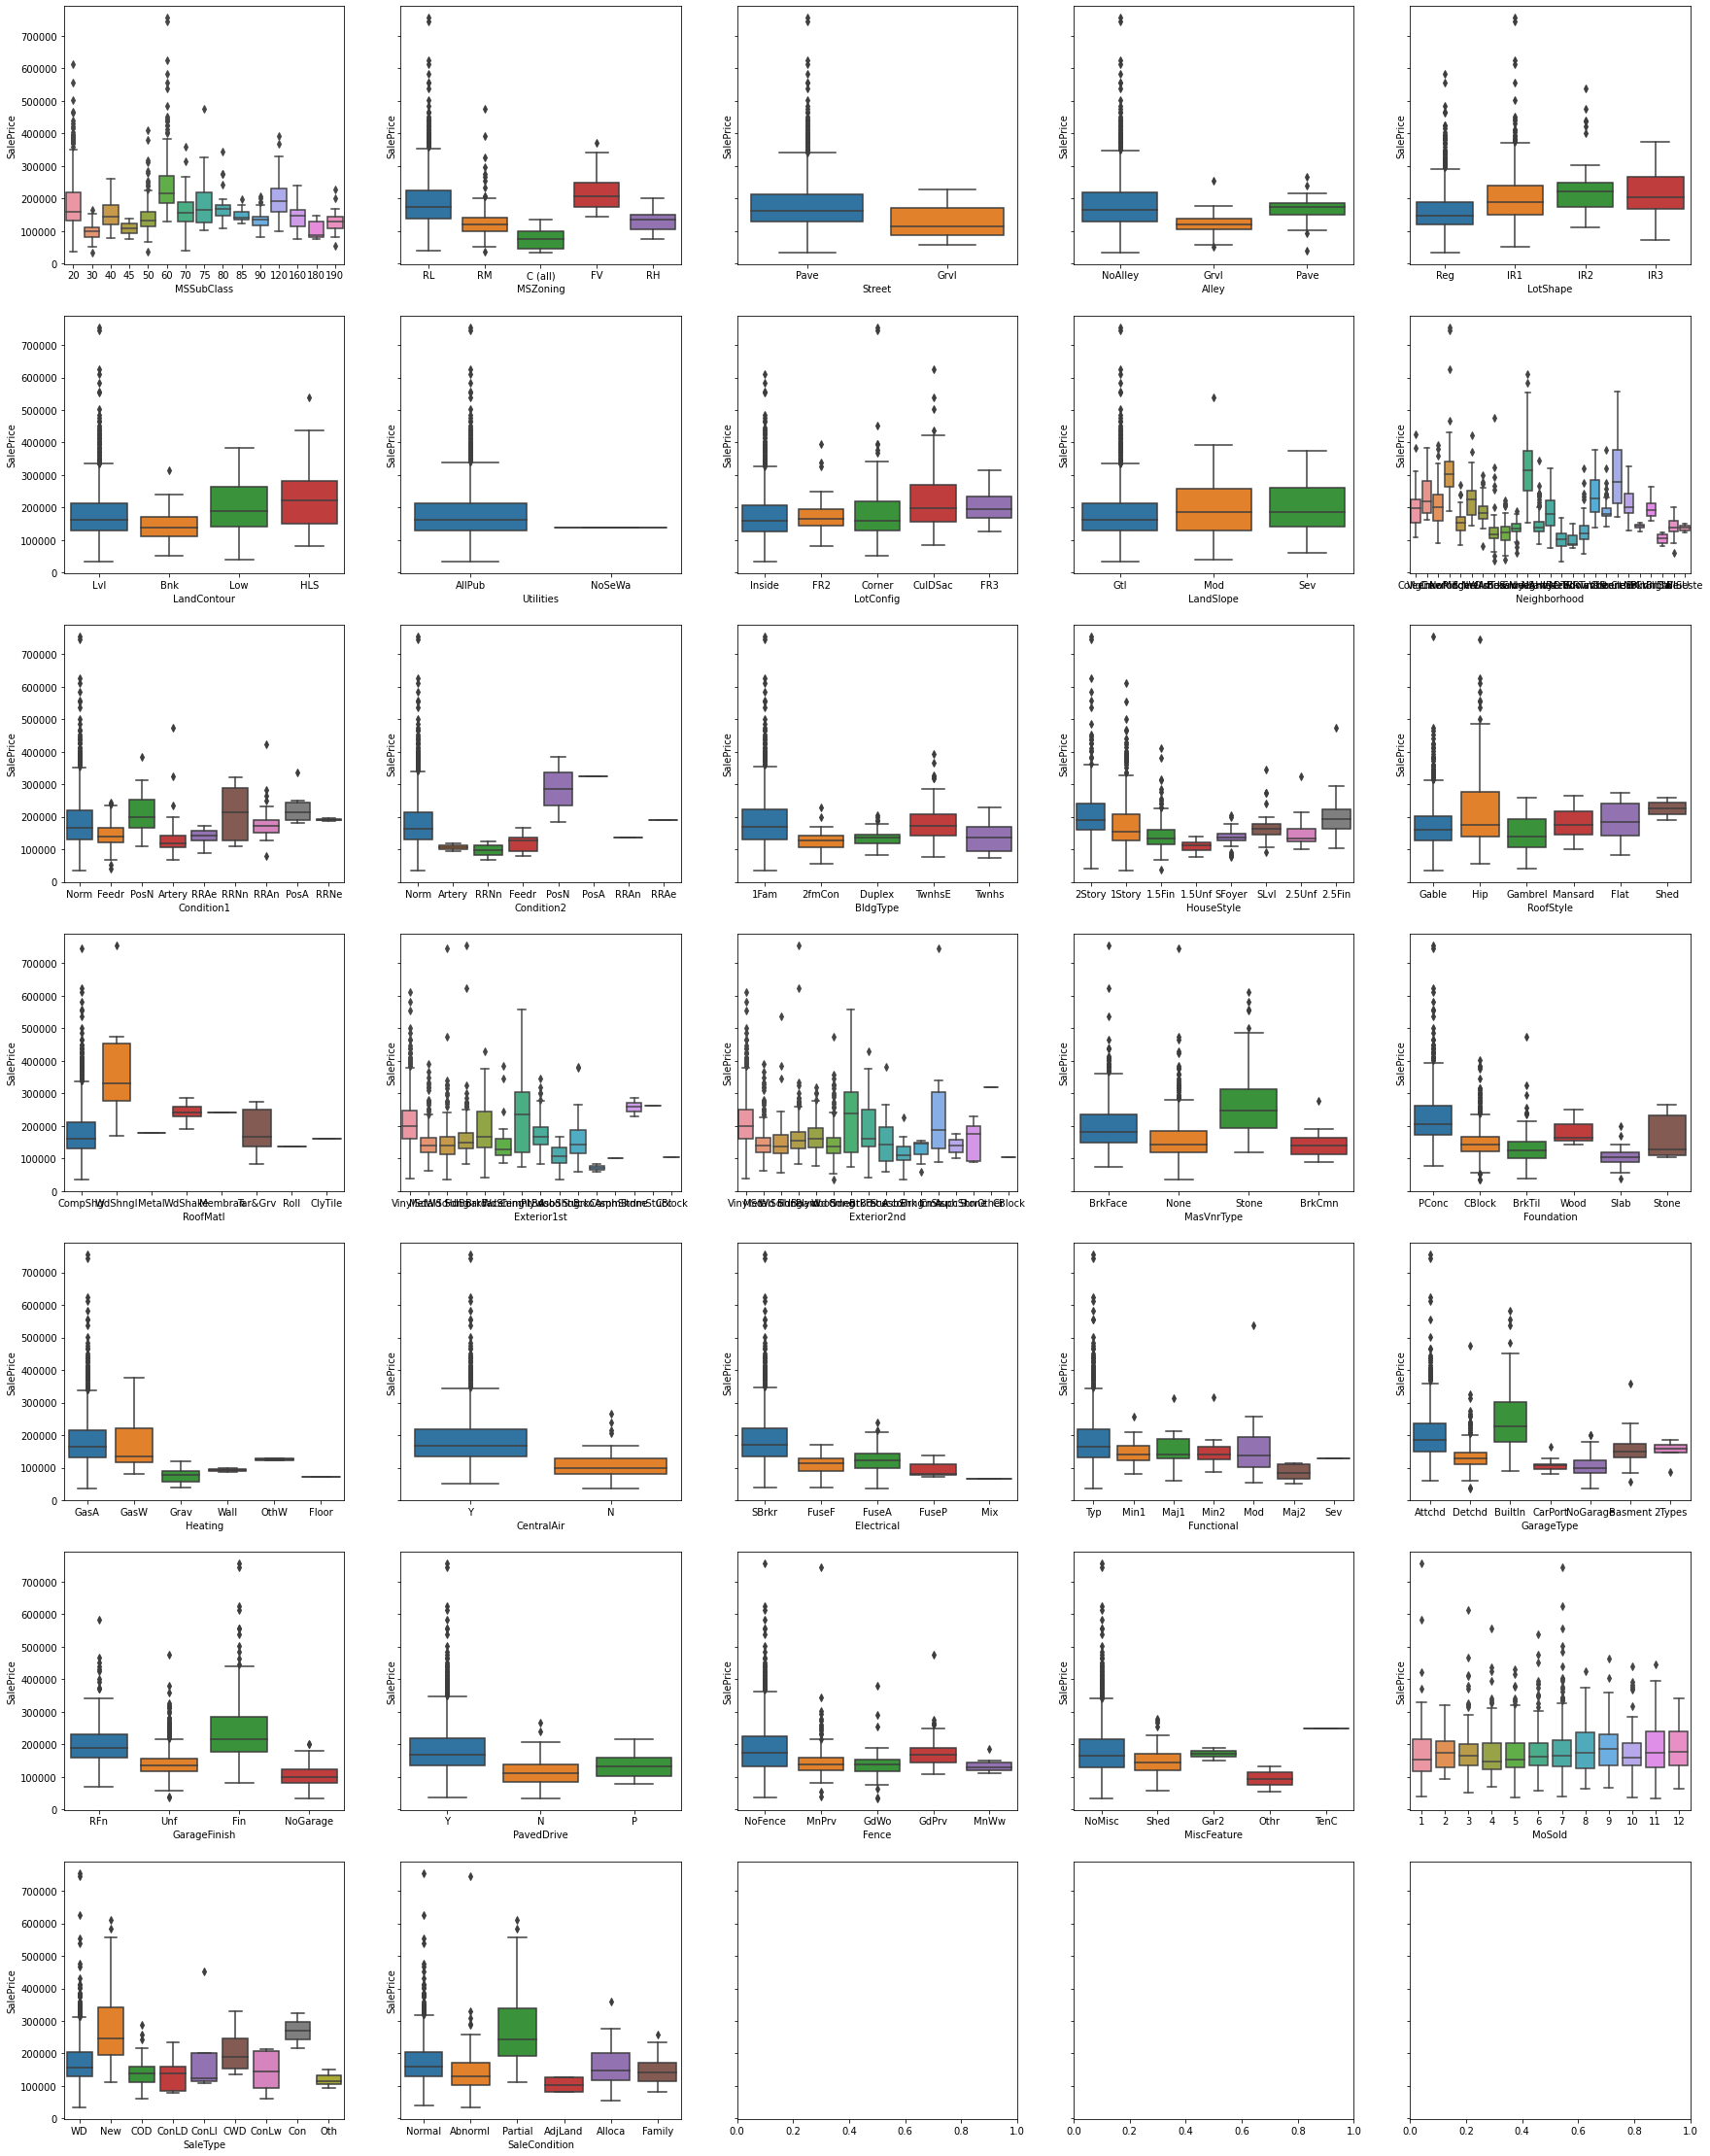

In [275]:
# Creating subplot axes
fig, axes = plt.subplots(7,5,figsize=(30,40), sharey=True)
for name, ax in zip(categorical_vars, axes.flatten()):
    sns.boxplot(y='SalePrice', x= name, data=housing_data, orient='v', ax=ax)
plt.show()


#### Inferences
- Almost all variables have some visible impact on SalePrice except Utilities, MoSold and LandSlope
- Utilities has only 1 value against NoSewa and remaining values against AllPub. Hence it will not add meaningful insights, better to drop


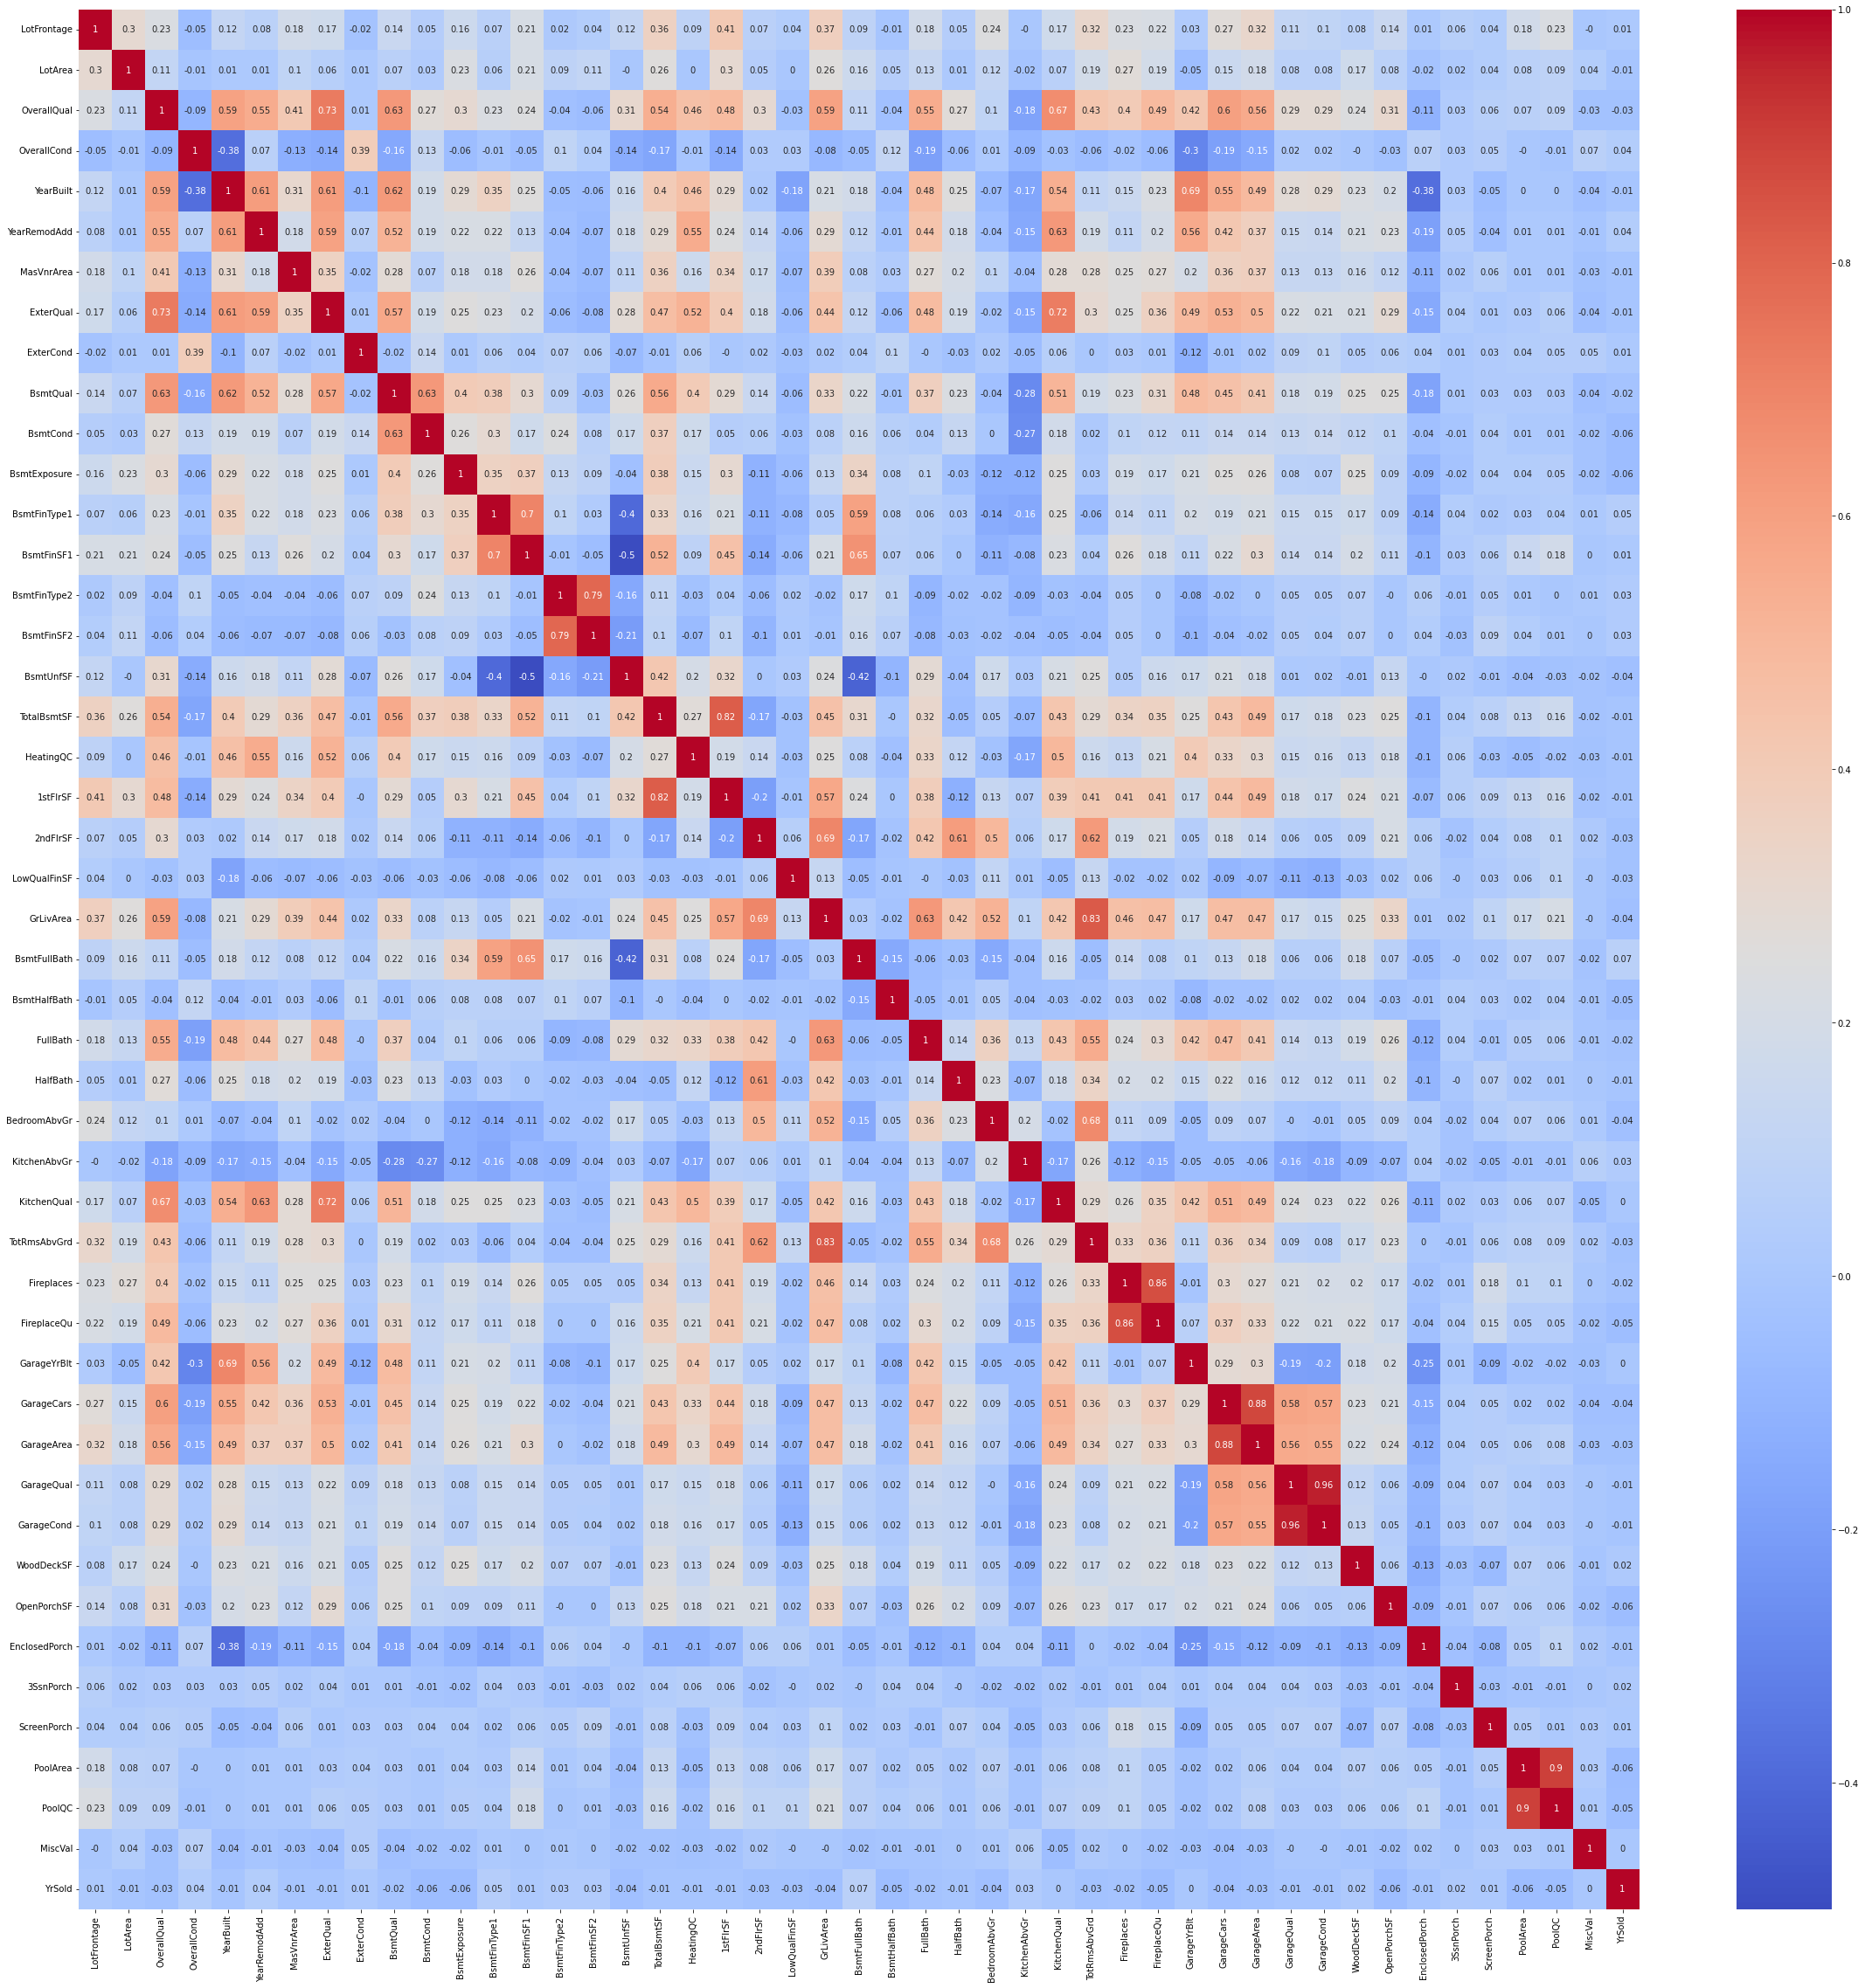

In [276]:
# Drop Id, Utilities and SalePrice for heatmap analysis
housing_data_ha = housing_data.drop(['Id','Utilities','SalePrice'],axis=1)
plt.figure(figsize=(40,40))
sns.heatmap(housing_data_ha.corr().round(2),annot=True,cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.show()

#### Inferences
- TotalBsmtSF and 1stFlrSF has 0.82 correlation, hence drop 1stFlrSF
- Fireplaces and FireplaceQu has 0.86 correlation, hence drop Fireplaces
- GarageCars and GarageArea has 0.88 correlation, hence drop GarageArea
- GarageQual and GarageCond has 0.96 correlation, hence drop GarageCond
- PoolArea and PoolQC has 0.9 correlation, hence drop PoolArea
- GrLivArea and TotRmsAbvGrd has 0.83 correlation, hence drop TotRmsAbvGrd

In [277]:
# Drop columns based on EDA
cols_to_be_dropped = ['Id','Utilities','1stFlrSF','Fireplaces','GarageArea','GarageCond','PoolArea','TotRmsAbvGrd']
housing_data.drop(cols_to_be_dropped,axis=1,inplace=True)
print(f"Number of columns after dropping {housing_data.columns.size}")

Number of columns after dropping 73


In [278]:
# Remove the dropped cols from continuous and categorical list
categorical_vars = [var for var in categorical_vars if var not in cols_to_be_dropped]
continuous_vars =  [var for var in continuous_vars if var not in cols_to_be_dropped]

### Step 4: Preparing the data for Modelling

#### Encoding

In [279]:
# Dummy Encoding for all categorical variables
# Certain Numbers in Categorical Variable are not mapped to string , it is read as string to interpret it better. For eg: OverallCond_10 would be easier to interpret than OverallCond_Very_Excellent
dummy_encoded_values = pd.get_dummies(data=housing_data[categorical_vars].astype(str),drop_first=True)
categorical_vars_encoded = list(dummy_encoded_values.columns)

# Add the new encoded cols to original dataframe and drop the source columns
housing_data = pd.concat([housing_data,dummy_encoded_values],axis=1)
housing_data.drop(categorical_vars,axis=1,inplace=True)
print(f"Number of columns after dummyEncoding {housing_data.columns.size}")

Number of columns after dummyEncoding 233


In [280]:
housing_data.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,6,4,104,53,196.0,3,2,4,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,5,7,77,26,0.0,2,2,4,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,6,4,102,52,162.0,3,2,4,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,6,4,19,20,0.0,2,2,3,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,7,4,101,50,350.0,3,2,4,...,0,0,0,0,1,0,0,0,1,0


#### Train test split

In [281]:
df_train, df_test = train_test_split(housing_data,train_size=0.7,random_state=100)
df_train.shape

(1021, 233)

#### Scaling the features using StandardScaler

In [282]:
scaler = StandardScaler()
scaler_continuous_vars = continuous_vars + ['SalePrice']
df_train[scaler_continuous_vars] = scaler.fit_transform(df_train[scaler_continuous_vars])
df_test[scaler_continuous_vars] = scaler.transform(df_test[scaler_continuous_vars])
df_train[scaler_continuous_vars]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,MiscVal,YrSold,SalePrice
318,0.925326,-0.057261,0.648310,-0.532073,0.723380,0.389207,0.809137,1.051361,-0.260816,0.577925,...,0.268059,1.988123,0.195951,1.912645,-0.121922,-0.275126,-0.058046,-0.084263,0.882411,1.004170
239,-0.795709,-0.169753,-0.066511,-1.448170,-0.930060,-1.698692,-0.558025,-0.699764,-0.260816,-0.533302,...,0.268059,-0.744598,1.405086,-0.368121,-0.121922,-0.275126,-0.058046,-0.084263,1.629460,-0.855161
986,-0.478677,-0.502762,-0.066511,2.216221,-2.032352,0.874765,-0.558025,-0.699764,2.602556,-0.533302,...,-1.121220,2.422143,-0.710899,-0.368121,-0.121922,-0.275126,-0.058046,-0.084263,-1.358737,-0.804567
1416,-0.433386,0.082504,-1.496155,0.384025,-2.376819,-1.698692,-0.558025,-0.699764,-0.260816,-0.533302,...,0.268059,-0.744598,-0.710899,1.437486,-0.121922,-0.275126,-0.058046,-0.084263,1.629460,-0.735000
390,-0.886290,-0.202365,-0.781333,2.216221,-2.204586,-1.698692,-0.558025,-0.699764,-0.260816,-0.533302,...,0.268059,-0.744598,1.253944,1.405809,-0.121922,-0.275126,-0.058046,-0.084263,0.135361,-0.779270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,-0.297515,-0.222359,0.648310,-0.532073,1.136740,0.971877,-0.558025,1.051361,-0.260816,0.577925,...,0.268059,-0.455251,-0.438844,-0.368121,-0.121922,-0.275126,-0.058046,-0.084263,0.135361,0.106126
53,-0.071063,3.861107,2.077954,-0.532073,0.310020,0.097872,-0.558025,1.051361,-0.260816,1.689151,...,0.268059,6.143466,0.377322,-0.368121,-0.121922,-0.275126,-0.058046,-0.084263,-1.358737,2.585234
350,-0.071063,-0.259144,2.077954,-0.532073,1.205633,1.068988,1.375227,2.802485,-0.260816,1.689151,...,0.268059,0.943259,0.105266,-0.368121,-0.121922,-0.275126,-0.058046,-0.084263,-0.611688,1.738555
79,-0.433386,-0.004850,-0.781333,0.384025,-2.032352,-0.193462,-0.558025,-0.699764,-0.260816,-0.533302,...,0.268059,-0.149830,-0.710899,1.659227,-0.121922,-0.275126,-0.058046,-0.084263,0.882411,-0.893106


### Step 5: Model Building and evaluation

#### Utilities

In [283]:
# Calculate Adjusted R2
def adjusted_r2(X,r2_score):
    n = len(X)
    p = len(X.columns)
    return 1-(1-r2_score)*(n-1)/(n-p-1)

In [312]:
#Create Model based on the need
def get_model(model_type,alpha=1.0):
    if model_type == 'Ridge':
        return Ridge(alpha=alpha)
    if model_type == 'Lasso':
        return Lasso(alpha=alpha)

    raise ValueError(f"Invalid Model Type {model_type}") 
    

In [331]:
# Find the best hyperparameter and then build Ridge or Lasso Model
def build_with_regularization(X_train,y_train,X_test,y_test,model_type,alpha_range,scoring='neg_root_mean_squared_error',folds=10):
    alpha_grid = [{'alpha': alpha_range}]
    grid_search_cv = GridSearchCV(get_model(model_type),param_grid= alpha_grid,scoring=scoring,cv=folds,n_jobs=-1,verbose=1,return_train_score=True)
    grid_search_cv.fit(X_train,y_train)
    best_alpha = grid_search_cv.best_params_['alpha']
    
    grid_cv_df = pd.DataFrame(grid_search_cv.cv_results_)[['param_alpha','mean_train_score','mean_test_score']]

    plt.figure(figsize=(20,10))
    plt.plot(grid_cv_df['param_alpha'],grid_cv_df['mean_train_score'],'b')
    plt.plot(grid_cv_df['param_alpha'],grid_cv_df['mean_test_score'],'r')
    plt.xlabel('alpha')
    plt.ylabel('Negative Mean Squared Error')
    plt.title("Negative Mean Squared Error vs alpha from GridSearch CV")
    plt.legend(['train score', 'test score'])
    plt.show()

    model = get_model(model_type,best_alpha)
    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    train_r2_score = r2_score(y_true=y_train,y_pred=y_train_pred)
    train_rmse = mean_squared_error(y_true=y_train,y_pred=y_train_pred)**0.5
    y_test_pred = model.predict(X_test)
    test_r2_score =  r2_score(y_true=y_test,y_pred=y_test_pred)
    test_rmse = mean_squared_error(y_true=y_test,y_pred=y_test_pred)**0.5
    metrics = [{'type_data': 'train', 'model_type': model_type,'r2': train_r2_score, 'rmse': train_rmse},{'type_data': 'test', 'model_type': model_type,'r2': test_r2_score, 'rmse': test_rmse}]
    print(f"Best Alpha: {best_alpha}")
    print(f"Best Score: {grid_search_cv.best_score_}")
    print(f"Training R2 Score: {train_r2_score}")
    print(f"Test R2 Score: {test_r2_score}")   
    return {'model': model, 'best_alpha': best_alpha, 'best_score': grid_search_cv.best_score_,'metrics':metrics,'grid_cv':grid_search_cv,'grid_cv_df': grid_cv_df}

In [317]:
# Evaluate the Assumptions of Linear Regression
def eval_lr_assumptions(model,X_train,y_train):
    # Residual analysis
    y_train_pred = model.predict(X_train)
    y_res = y_train - y_train_pred
    # Residual v/s predictions plot
    plt.scatter( y_train_pred , y_res)
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel("Sale Price")
    plt.ylabel("Residual")
    plt.title('Residual versus Sale Price prediction plot')
    plt.show()

    # Distribution of errors
    p = sns.distplot(y_res,kde=True)
    p = plt.title('Normality of error terms/residuals')
    plt.xlabel("Residuals")
    plt.show()

#### Step 5.1: Model Building Without Regularization

In [287]:
# Splitting the training data into X and y
y_train = df_train.pop('SalePrice')
X_train = df_train
y_test = df_test.pop('SalePrice')
X_test = df_test

In [288]:
# Create Linear Regression Model
lm = LinearRegression()
lm.fit(X_train,y_train)

# Running RFE with output number of values as 50
output_var_count = 50
rfe = RFE(lm,n_features_to_select=output_var_count)
rfe = rfe.fit(X_train, y_train)

In [289]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 44),
 ('LotArea', False, 27),
 ('OverallQual', True, 1),
 ('OverallCond', False, 26),
 ('YearBuilt', False, 16),
 ('YearRemodAdd', False, 179),
 ('MasVnrArea', False, 36),
 ('ExterQual', False, 105),
 ('ExterCond', False, 144),
 ('BsmtQual', False, 71),
 ('BsmtCond', False, 40),
 ('BsmtExposure', False, 9),
 ('BsmtFinType1', False, 174),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinType2', False, 171),
 ('BsmtFinSF2', False, 5),
 ('BsmtUnfSF', False, 2),
 ('TotalBsmtSF', True, 1),
 ('HeatingQC', False, 166),
 ('2ndFlrSF', False, 50),
 ('LowQualFinSF', False, 113),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 135),
 ('BsmtHalfBath', False, 165),
 ('FullBath', False, 175),
 ('HalfBath', False, 172),
 ('BedroomAbvGr', False, 137),
 ('KitchenAbvGr', False, 38),
 ('KitchenQual', False, 29),
 ('FireplaceQu', False, 170),
 ('GarageYrBlt', False, 127),
 ('GarageCars', False, 76),
 ('GarageQual', False, 86),
 ('WoodDeckSF', False, 149),
 ('OpenPorchSF', False, 142),
 ('Enclo

In [290]:
resulting_rfe_cols = X_train.columns[rfe.support_]
resulting_rfe_cols

Index(['OverallQual', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea',
       'MSSubClass_190', 'MSSubClass_75', 'MSSubClass_90', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'LotConfig_CulDSac',
       'LotConfig_FR3', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Condition1_Norm',
       'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe',
       'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs',
       'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'RoofStyle_Shed',
       'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake',
       'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_CemntBd',
       'Exterior1st_Stone', 'Exterior2nd_AsphShn', 'Exterior2nd_CmentBd',
       'Exterior2nd_Stone', 'Heating_OthW', 'Heating_Wall', 'Functional_Min1',
       'Functional_Min2', 'Functional_Sev', 'Functional_Typ',
       'MiscFeature_Othr', 'Sale

In [291]:
X_train.columns[~rfe.support_]

Index(['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       ...
       'SaleType_CWD', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_Oth', 'SaleType_WD', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal'],
      dtype='object', length=182)

In [292]:
# Keeping only the columns from RFE
X_train_rfe = X_train[resulting_rfe_cols]
X_test_rfe = X_test[resulting_rfe_cols]

In [293]:
# Create Linear Regression Model
lm = LinearRegression()
lm.fit(X_train_rfe,y_train)
y_train_pred = lm.predict(X_train_rfe)
y_test_pred = lm.predict(X_test_rfe)
train_r2_score  = r2_score(y_true=y_train,y_pred=y_train_pred)
train_adj_r2_scopre = adjusted_r2(X_train_rfe,train_r2_score)
test_r2_score  = r2_score(y_true=y_test,y_pred=y_test_pred)
test_adj_r2_score = adjusted_r2(X_test_rfe,test_r2_score)
print(f"R2 score of training {train_r2_score}")
print(f"Adj R2 score of training {train_adj_r2_scopre}")
print(f"R2 score of test {test_r2_score}")
print(f"Adj R2 score of test {test_adj_r2_score}")

R2 score of training 0.8875628391356951
Adj R2 score of training 0.8817671091942361
R2 score of test 0.7709543022058997
Adj R2 score of test 0.7414381040365567


##### Inference
- Even though R2 and Adj R2 score for training set seems to be decent , it miserably failed for test data. Let's proceed with Regularization to improve the model further

#### Step 5.2: Model Building With Ridge

Building Model Using Ridge 
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


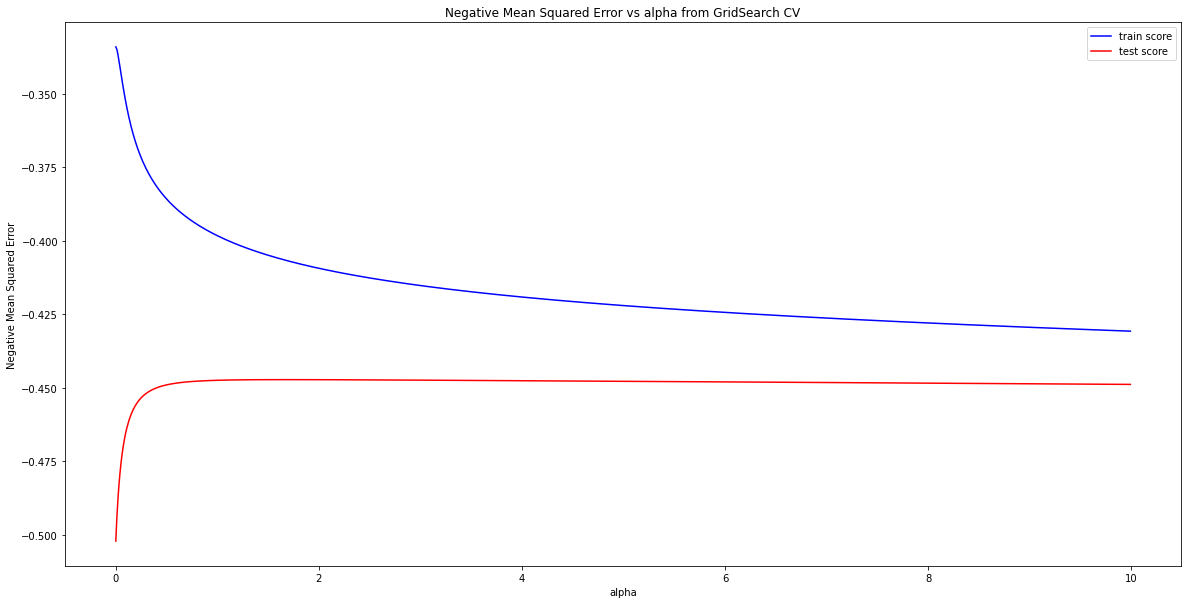

Best Alpha: 1.6709999999999996
Best Score: -0.4471873358814726
Training R2 Score: 0.8327268103879261
Test R2 Score: 0.8217589179078723


In [336]:
print(f"Building Model Using Ridge ")
ridge_alphas = list(np.arange(0.001, 10,0.01))
ridge_result = build_with_regularization(X_train_rfe,y_train,X_test_rfe,y_test,'Ridge',ridge_alphas)

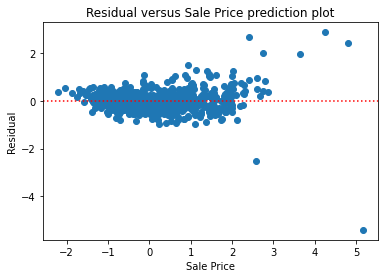

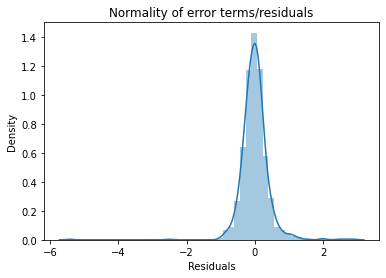

In [319]:
# Evaluate Regression Assumptions for Ridge
eval_lr_assumptions(ridge_result['model'],X_train_rfe,y_train)

##### Inferences:
- From Residual versus Sale Price prediction plot,  we could confirm that linear relationship between independent and dependent variables. Also error terms are independent of each other with constant variance. 
  We could see that there are some unexplained variance at higher value of sale price (could be due to outliers).
- From Normality of error terms/residuals plot, we could confirm that Residual is normally distributed with zero mean

In [350]:
ridge_coeff_df = pd.DataFrame({'Features':X_train_rfe.columns, 'Coefficients':ridge_result['model'].coef_.round(4),'ABS_Coefficients': abs(ridge_result['model'].coef_.round(4))}).sort_values('ABS_Coefficients',ascending=False)
ridge_coeff_df.reset_index(drop=True,inplace=True)
ridge_coeff_df

,Features,Coefficients,ABS_Coefficients
0,Condition2_PosN,-1.5127,1.5127
1,RoofMatl_WdShngl,1.3069,1.3069
2,Neighborhood_NoRidge,0.6032,0.6032
3,Neighborhood_NridgHt,0.5899,0.5899
4,Heating_OthW,-0.5862,0.5862
5,RoofMatl_CompShg,0.4574,0.4574
6,RoofMatl_Membran,0.4293,0.4293
7,GrLivArea,0.4124,0.4124
8,RoofMatl_Tar&Grv,0.3803,0.3803
9,OverallQual,0.3585,0.3585


#### Step 5.3: Model Building With Lasso

Building Model Using Lasso 
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


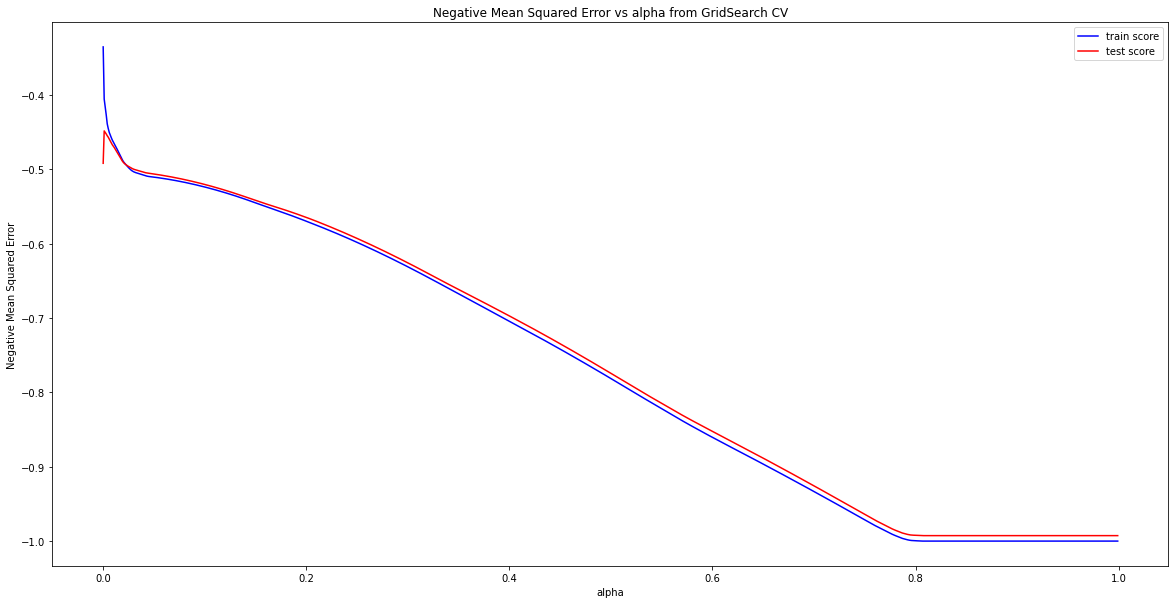

Best Alpha: 0.0011
Best Score: -0.44822689814842465
Training R2 Score: 0.8323283425705535
Test R2 Score: 0.8138957794709116


In [337]:
print(f"Building Model Using Lasso ")
lasso_alphas = list(np.arange(0.0001, 1, 0.001))
lasso_result = build_with_regularization(X_train_rfe,y_train,X_test_rfe,y_test,'Lasso',lasso_alphas)

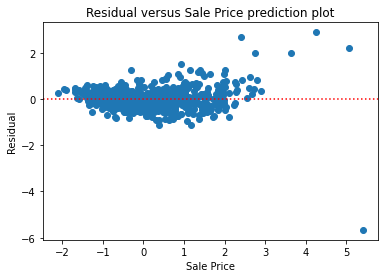

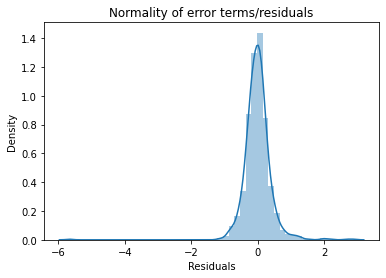

In [318]:
# Evaluate Regression Assumptions for Lasso
eval_lr_assumptions(lasso_result['model'],X_train_rfe,y_train)

##### Inferences:
- From Residual versus Sale Price prediction plot,  we could confirm that linear relationship between independent and dependent variables. Also error terms are independent of each other with constant variance. 
  We could see that there are some unexplained variance at higher value of sale price (could be due to outliers).
- From Normality of error terms/residuals plot, we could confirm that Residual is normally distributed with zero mean

In [351]:
lasso_coeff_df = pd.DataFrame({'Features':X_train_rfe.columns, 'Coefficients':lasso_result['model'].coef_.round(4),'ABS_Coefficients': abs(lasso_result['model'].coef_.round(4))}).sort_values('ABS_Coefficients',ascending=False)
lasso_coeff_df.reset_index(drop=True,inplace=True)
lasso_coeff_df

,Features,Coefficients,ABS_Coefficients
0,Condition2_PosN,-2.9960,2.9960
1,RoofMatl_WdShngl,1.3690,1.3690
2,Neighborhood_NoRidge,0.5839,0.5839
3,Neighborhood_NridgHt,0.5694,0.5694
4,Heating_OthW,-0.4289,0.4289
5,GrLivArea,0.4096,0.4096
6,OverallQual,0.3670,0.3670
7,Neighborhood_Somerst,0.2979,0.2979
8,BldgType_Twnhs,-0.2869,0.2869
9,RoofMatl_CompShg,0.2640,0.2640


### Step 6: Comparison of Ridge and Lasso


In [352]:
print(f"# Ridge Coefficients: {len(ridge_coeff_df)}")
print(f"# Lasso Coefficients: {len(lasso_coeff_df[lasso_coeff_df['ABS_Coefficients'] != 0])}")

# Ridge Coefficients: 50
# Lasso Coefficients: 29


In [354]:
combined_metrics =pd.DataFrame(ridge_result['metrics'] + lasso_result['metrics'])
combined_metrics

,type_data,model_type,r2,rmse
0,train,Ridge,0.832727,0.408990
1,test,Ridge,0.821759,0.428426
2,train,Lasso,0.832328,0.409477
3,test,Lasso,0.813896,0.437774


#### Inferences
- Lasso uses significantly less number of independent variable for the model (only 29 out of total 50 from RFE)
- Yet Lasso is able to explain the data relatively better. R2 and RMSE is comparable, merely 0.0004 lesser R2 score and 0.001 greater rmse for training data
- Ridge outperforms Lasso for the test data. But trading off complexity vs variance, I would go for Lasso